In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load dataset
data = pd.read_csv("/content/sample_data/Tayko.csv")
# Filter for only purchasers - Including non-purchasers in the model would skew results and make it harder to identify patterns among actual purchasers.
data = data[data['Purchase'] == 1]
# Split into training (60%) and validation (40%)
train, val = train_test_split(data, test_size=0.4, random_state=42)
# Define predictors and target - You need to drop Spending, Purchase, and sequence_number from X_train because they are either the target variable or not useful for prediction
X_train = train.drop(columns=['Spending', 'Purchase', 'sequence_number'])  # Drop unnecessary columns
y_train = train['Spending']
X_val = val.drop(columns=['Spending', 'Purchase', 'sequence_number'])
y_val = val['Spending']
# Standardize numerical features (for regression model)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Store the data in a new dataframe and preserve the index of the original dataframe
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index) # new
# MULTIPLE LINEAR REGRESSION (STEPWISE)
def stepwise_selection(X, y):
    included = []
    while True:
        changed = False
        excluded = list(set(X.columns) - set(included))
        new_pvals = pd.Series(index=excluded)
        for new_column in excluded:
            # The following model should work now since we are using a dataframe that retains its index values
            model = sm.OLS(y, sm.add_constant(X[included + [new_column]])).fit()
            new_pvals[new_column] = model.pvalues[new_column]
        best_pval = new_pvals.min()
        if best_pval < 0.05:
            best_feature = new_pvals.idxmin()
            included.append(best_feature)
            changed = True
        if not changed:
            break
    return included

selected_features = stepwise_selection(X_train_scaled_df, y_train)
# Train final linear regression model
X_train_final = X_train[selected_features]
X_val_final = X_val[selected_features]
model_lr = LinearRegression()
model_lr.fit(X_train_final, y_train)

# Predictions and Evaluation (Linear Regression)
y_pred_lr = model_lr.predict(X_val_final)
rmse_lr = np.sqrt(mean_squared_error(y_val, y_pred_lr))
r2_lr = r2_score(y_val, y_pred_lr)

# REGRESSION TREE
model_tree = DecisionTreeRegressor(max_depth=5, min_samples_split=10, random_state=42)
model_tree.fit(X_train, y_train)

# Predictions and Evaluation (Regression Tree)
y_pred_tree = model_tree.predict(X_val)
rmse_tree = np.sqrt(mean_squared_error(y_val, y_pred_tree))
r2_tree = r2_score(y_val, y_pred_tree)

# Compare models
print("Linear Regression RMSE:", rmse_lr, "R2:", r2_lr)
print("Regression Tree RMSE:", rmse_tree, "R2:", r2_tree)

# Select the best model
best_model = "Linear Regression" if r2_lr > r2_tree else "Regression Tree"
print("Best Model:", best_model)



Linear Regression RMSE: 173.9752473132138 R2: 0.4673380836930663
Regression Tree RMSE: 190.19900606773942 R2: 0.36336104595367336
Best Model: Linear Regression


Understanding the Metrics:
Root Mean Squared Error (RMSE):

Measures the average prediction error in the same unit as the target variable (Spending).
Lower RMSE is better, meaning the model makes more accurate predictions.
Linear Regression RMSE (173.97) is lower than Regression Tree RMSE (190.20) → Linear Regression has smaller prediction errors.
R-squared (R²):

Measures how well the model explains the variation in Spending.
Ranges from 0 to 1, where 1 means perfect prediction and 0 means no predictive power.
Linear Regression R² (0.467) is higher than Regression Tree R² (0.363) → It explains 46.7% of spending variation, while the tree only explains 36.3%.

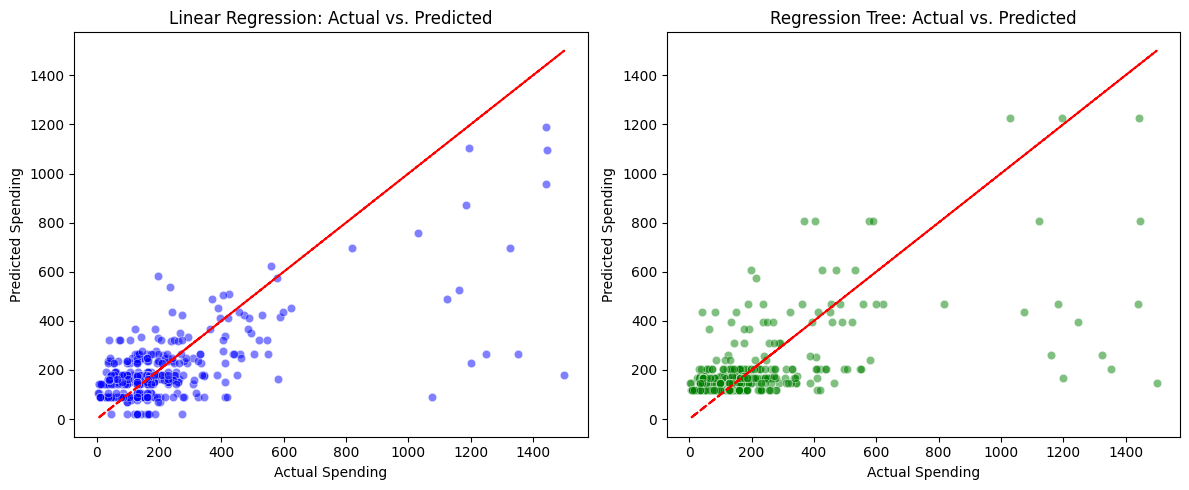

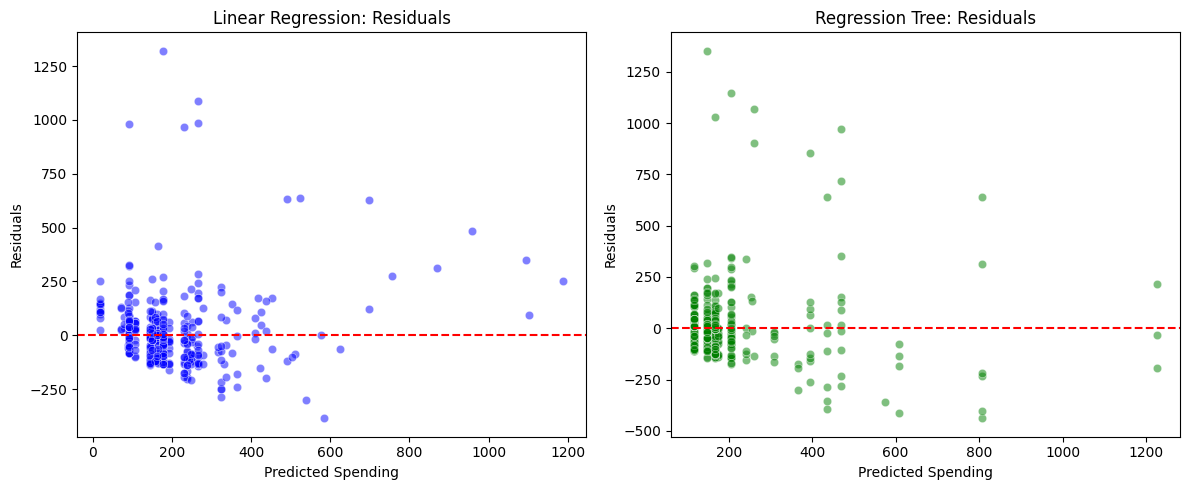

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Predictions for both models
y_pred_lr = model_lr.predict(X_val_final)  # Linear Regression
y_pred_tree = model_tree.predict(X_val)  # Regression Tree

# Scatter Plot: Actual vs. Predicted Spending
plt.figure(figsize=(12, 5))

# Linear Regression
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_val, y=y_pred_lr, alpha=0.5, color="blue")
plt.plot(y_val, y_val, color="red", linestyle="--")  # 45-degree line
plt.xlabel("Actual Spending")
plt.ylabel("Predicted Spending")
plt.title("Linear Regression: Actual vs. Predicted")

# Regression Tree
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_val, y=y_pred_tree, alpha=0.5, color="green")
plt.plot(y_val, y_val, color="red", linestyle="--")  # 45-degree line
plt.xlabel("Actual Spending")
plt.ylabel("Predicted Spending")
plt.title("Regression Tree: Actual vs. Predicted")

plt.tight_layout()
plt.show()

# Residual Plot: Errors vs. Predictions
plt.figure(figsize=(12, 5))

# Linear Regression Residuals
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_pred_lr, y=y_val - y_pred_lr, alpha=0.5, color="blue")
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted Spending")
plt.ylabel("Residuals")
plt.title("Linear Regression: Residuals")

# Regression Tree Residuals
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_pred_tree, y=y_val - y_pred_tree, alpha=0.5, color="green")
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted Spending")
plt.ylabel("Residuals")
plt.title("Regression Tree: Residuals")

plt.tight_layout()
plt.show()



Scatter Plot (Actual vs. Predicted)

Closer to the red diagonal line = better model.
If points spread out randomly with no clear pattern, predictions are accurate.
If a model has more deviation from the line, it is less accurate.

Residual Plot (Errors vs. Predictions)

Residuals should be randomly scattered around 0.
Patterns or funnel shapes indicate problems like heteroscedasticity (uneven variance).
If errors are larger for high-spending customers, the model may need improvement.

**Linear Regression is the better model here because:**

It has a tighter fit to actual spending.
Residuals are more evenly distributed.
RMSE and R² confirm its better performance.
Regression Tree struggles more, with:

Higher residual errors.
More variance in predictions.
Worse generalization for higher spending customers.


In [11]:
#Evaluate Model Performance on Both Training & Validation Data

from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Predictions on training data
y_train_pred_lr = model_lr.predict(X_train_final)  # Linear Regression
y_train_pred_tree = model_tree.predict(X_train)  # Regression Tree

# Predictions on validation data
y_val_pred_lr = model_lr.predict(X_val_final)
y_val_pred_tree = model_tree.predict(X_val)

# Calculate RMSE and R² for both models
def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return rmse, r2

# Training performance
rmse_train_lr, r2_train_lr = evaluate_model(y_train, y_train_pred_lr)
rmse_train_tree, r2_train_tree = evaluate_model(y_train, y_train_pred_tree)

# Validation performance
rmse_val_lr, r2_val_lr = evaluate_model(y_val, y_val_pred_lr)
rmse_val_tree, r2_val_tree = evaluate_model(y_val, y_val_pred_tree)

# Print results
print("Linear Regression:")
print(f"Train RMSE: {rmse_train_lr}, Train R²: {r2_train_lr}")
print(f"Validation RMSE: {rmse_val_lr}, Validation R²: {r2_val_lr}\n")

print("Regression Tree:")
print(f"Train RMSE: {rmse_train_tree}, Train R²: {r2_train_tree}")
print(f"Validation RMSE: {rmse_val_tree}, Validation R²: {r2_val_tree}")


Linear Regression:
Train RMSE: 159.0794944326172, Train R²: 0.41443667445796917
Validation RMSE: 173.9752473132138, Validation R²: 0.4673380836930663

Regression Tree:
Train RMSE: 140.1501165030712, Train R²: 0.5455015665857909
Validation RMSE: 190.19900606773942, Validation R²: 0.36336104595367336


**Understanding RMSE (Root Mean Squared Error)**
RMSE measures the average error (difference between actual and predicted values).
Lower RMSE is better because it means the model makes smaller errors in predictions.
RMSE is in the same unit as the target variable (Spending).

**Understanding R² (R-Squared)**
R² measures how well the model explains variance in Spending.
Higher R² is better (closer to 1 means the model explains more variance).
If R² is too low, the model isn’t explaining much of the spending variation.

**1. Linear Regression**

Good generalization: The model performs consistently across training and validation.
Slight improvement on validation R²: Suggests that the training data might not be perfectly representative, but the model isn’t overfitting.

**Regression Tree Overfitting:**

The model is too good on training data (low RMSE, high R²), meaning it memorized patterns instead of learning general rules.
The validation performance drops significantly (higher RMSE, lower R²), meaning it struggles on new data.




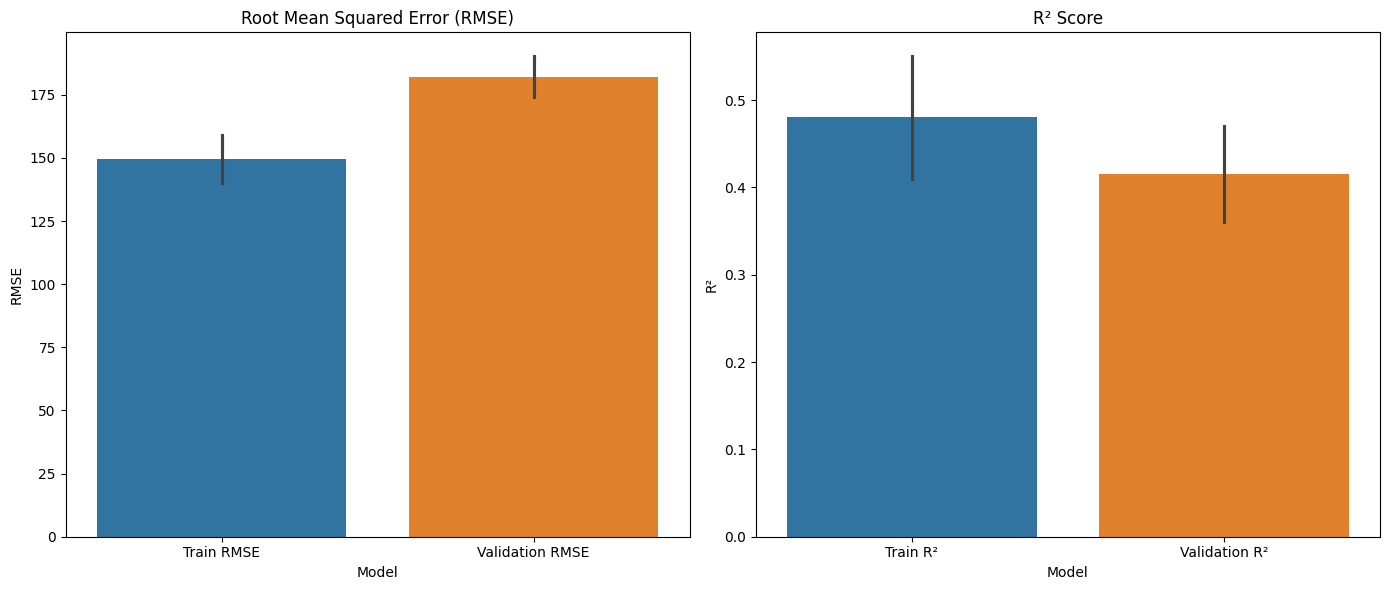

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Data
models = ['Linear Regression', 'Regression Tree']
metrics = ['Train RMSE', 'Validation RMSE', 'Train R²', 'Validation R²']
values = [
    [159.08, 173.98, 0.41, 0.47],  # Linear Regression
    [140.15, 190.20, 0.55, 0.36]   # Regression Tree
]

# Create DataFrame
df = pd.DataFrame(values, columns=metrics, index=models)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# RMSE Plot
sns.barplot(data=df[['Train RMSE', 'Validation RMSE']], ax=axes[0])
axes[0].set_title('Root Mean Squared Error (RMSE)')
axes[0].set_ylabel('RMSE')
axes[0].set_xlabel('Model')

# R² Plot
sns.barplot(data=df[['Train R²', 'Validation R²']], ax=axes[1])
axes[1].set_title('R² Score')
axes[1].set_ylabel('R²')
axes[1].set_xlabel('Model')

plt.tight_layout()
plt.show()
